<a href="https://colab.research.google.com/github/najwhoas/bnpl-knowledge-mining-paper/blob/main/evaluate_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import model repository
!git clone https://github.com/najwhoas/nlp-bnpl.git

Cloning into 'nlp-bnpl'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 52 (delta 13), reused 11 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 16.08 MiB | 11.84 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
# Install libraries
!pip install --ignore-installed -r /content/nlp-bnpl/requirements.txt
!pip install scikit-learn==1.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.8/457.8 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 825.0 kB/s eta 0:00:00
Processing /colabtools/dist/google_colab-1.0.0.tar.gz (from -r /content/nlp-bnpl/requirements.txt (line 273))
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/colabtools/dist/google_colab-1.0.0.tar.gz'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 84.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import joblib
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from safetensors.torch import load_file
import shap

In [ ]:
# Retrieve dataset
data = pd.read_csv('/content/nlp-bnpl/data/bnpl-dataset.csv').query("factor_label != 'Outlier'")

In [ ]:
# Feature preparation for classification task

embedded_txt = load_file("/content/nlp-bnpl/model_dir/sentiment_model_dir/text_embeddings.safetensors") # Load the embedded text

X = embedded_txt["embeddings"].numpy() # Extract the embeddings tensor and convert to numpy array
y = data["score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) # Split dataset

In [ ]:
# Evaluate classification models

models = {
    "NN": "/content/nlp-bnpl/model_dir/sentiment_model_dir/clf_nn.pkl",
    "XGB": "/content/nlp-bnpl/model_dir/sentiment_model_dir/clf_xgb.joblib",
    "RF": "/content/nlp-bnpl/model_dir/sentiment_model_dir/clf_rf.joblib",
    "SVM": "/content/nlp-bnpl/model_dir/sentiment_model_dir/clf_svm.joblib"
}

for model_name, model_path in models.items():
    clf = joblib.load(model_path)
    pred = clf.predict(X_test)
    if model_name == "NN":
      pred = np.argmax(pred, axis=1)
    print(f"===== {model_name} Model =====")
    if model_name == "XGB" or model_name=="NN":
      print("Balanced Accuracy:", balanced_accuracy_score(y_test-1, pred))
      print(classification_report(y_test-1, pred))
    else:
      print("Balanced Accuracy:", balanced_accuracy_score(y_test, pred))
      print(classification_report(y_test, pred))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
===== NN Model =====
Balanced Accuracy: 0.38332744424630694
              precision    recall  f1-score   support

           0       0.66      0.89      0.76       270
           1       0.17      0.04      0.06        54
           2       0.08      0.02      0.03        48
           3       0.38      0.12      0.18        49
           4       0.80      0.85      0.83       309

    accuracy                           0.70       730
   macro avg       0.42      0.38      0.37       730
weighted avg       0.63      0.70      0.65       730

===== XGB Model =====
Balanced Accuracy: 0.3604361960533944
              precision    recall  f1-score   support

           0       0.64      0.88      0.74       270
           1       0.07      0.02      0.03        54
           2       0.00      0.00      0.00        48
           3       0.30      0.06      0.10        49
           4       0.82      0.84      0.83       309

    accuracy              

In [ ]:
# Feature preparation for predictive task
data = pd.get_dummies(data, columns=["factor_label"], prefix="factor", dtype=int)

X = data.filter(like="factor_")
y = data["score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) # Split dataset

In [ ]:
# Evaluate predictive models

models = {
    "NN": "/content/nlp-bnpl/model_dir/sentiment_model_dir/reg_nn.pkl",
    "XGB": "/content/nlp-bnpl/model_dir/sentiment_model_dir/reg_xgb.joblib",
    "RF_reg": "/content/nlp-bnpl/model_dir/sentiment_model_dir/reg_rf.joblib",
    "SVM": "/content/nlp-bnpl/model_dir/sentiment_model_dir/reg_svm.joblib"
}

for model_name, model_path in models.items():
    reg = joblib.load(model_path)
    pred = reg.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    print(f"===== {model_name} Model =====")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R² score: {r2:.4f}\n")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
===== NN Model =====
MAE: 1.2515
MSE: 2.3994
R² score: 0.2737

===== XGB Model =====
MAE: 1.4563
MSE: 2.4919
R² score: 0.2457

===== RF_reg Model =====
MAE: 1.2642
MSE: 2.3247
R² score: 0.2963

===== SVM Model =====
MAE: 1.1802
MSE: 2.8142
R² score: 0.1482



In [ ]:
# Interpretable ML with SHAP (SHapley Additive exPlanations)
model = joblib.load("/content/nlp-bnpl/model_dir/sentiment_model_dir/reg_rf.joblib")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

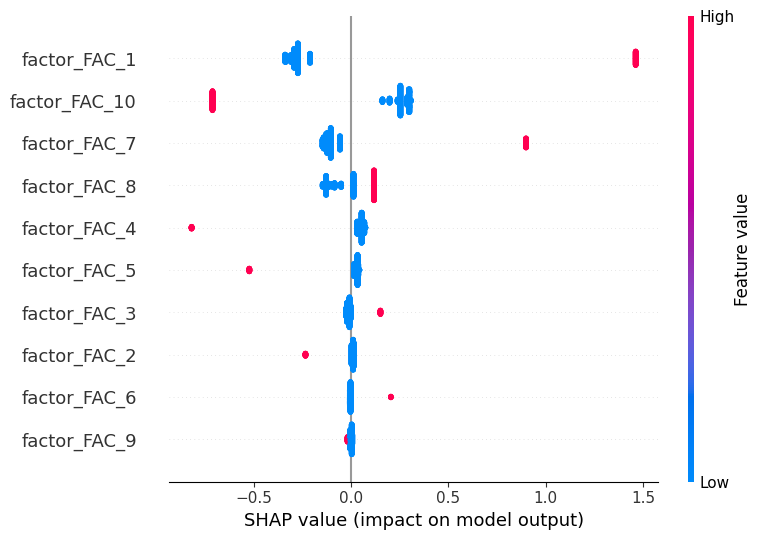

In [ ]:
# Visualize SHAP summary plot 1
shap.summary_plot(shap_values, X_test)

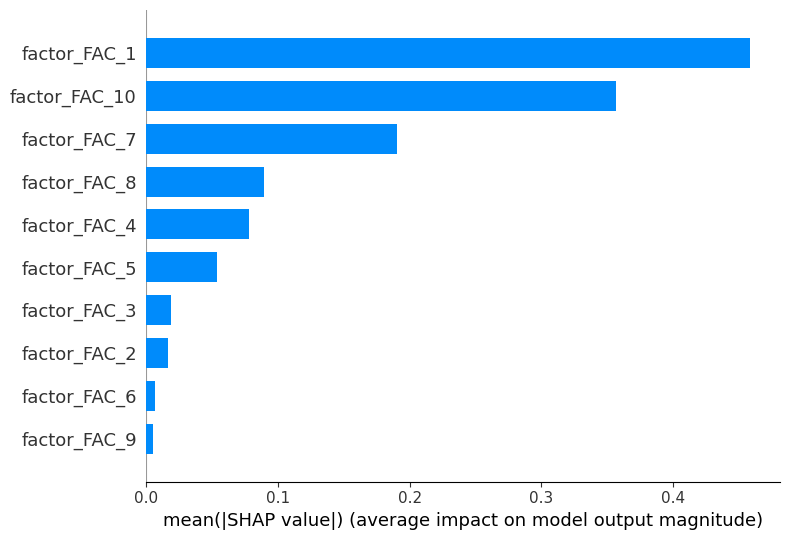

In [ ]:
# Visualize SHAP summary plot 2
shap.summary_plot(shap_values, X_test, plot_type='bar')